# Importation des librairies

In [1]:
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import os.path

from sklearn.tree import plot_tree
from sklearn.model_selection import train_test_split
from sksurv.ensemble import RandomSurvivalForest
from sksurv.linear_model import CoxPHSurvivalAnalysis
from sksurv.metrics import concordance_index_censored , concordance_index_ipcw
from sklearn.impute import SimpleImputer
from sksurv.util import Surv
from lifelines.utils import concordance_index



# Preprocessing

In [2]:
clinical_test=pd.read_csv('data/clinical_test.csv')
clinical_train=pd.read_csv('data/clinical_train.csv')

molecular_test=pd.read_csv('data/molecular_test.csv')
molecular_train=pd.read_csv('data/molecular_train.csv')


In [3]:
target_df=pd.read_csv('data/target_train.csv')

# Drop rows where 'OS_YEARS' is NaN if conversion caused any issues
target_df.dropna(subset=['OS_YEARS', 'OS_STATUS'], inplace=True)


# Contarget_dfvert 'OS_YEARS' to numeric if it isn’t already
target_df['OS_YEARS'] = pd.to_numeric(target_df['OS_YEARS'], errors='coerce')

# Ensure 'OS_STATUS' is boolean
target_df['OS_STATUS'] = target_df['OS_STATUS'].astype(bool)

In [4]:
from sklearn.impute import KNNImputer

def precise_missing_values(df):
    # Imputation KNN pour les variables numériques
    num_cols = df.select_dtypes(include=['float64', 'int64']).columns
    imputer = KNNImputer(n_neighbors=5)
    df[num_cols] = imputer.fit_transform(df[num_cols])

    # Pour les variables catégorielles, on remplace par 'Missing'
    cat_cols = df.select_dtypes(include=['object']).columns
    for col in cat_cols:
        df[col] = df[col].fillna('Missing')
    return df

clinical_train = precise_missing_values(clinical_train)
clinical_test = precise_missing_values(clinical_test)
molecular_train = precise_missing_values(molecular_train)
molecular_test = precise_missing_values(molecular_test)

In [5]:
import pandas as pd
import numpy as np

def aggregate_leukemia_data_improved(df, clinical_df=None):
    """
    Agrégation avancée des données de mutations par patient avec intégration
    des facteurs pronostiques ELN 2022 et des recommandations cliniques.
    (Version sans intégration des données cliniques)
    """
    # === DÉFINITIONS DES GÈNES SELON ELN 2022 ===
    adverse_genes = {
        'TP53', 'ASXL1', 'RUNX1', 'EZH2', 'SF3B1', 'SRSF2', 'U2AF1', 
        'ZRSR2', 'STAG2', 'BCOR', 'SETBP1'
    }
    dna_methylation_genes = {'DNMT3A', 'TET2', 'IDH1', 'IDH2'}
    favorable_genes = {'NPM1', 'CEBPA'}
    all_genes = [
        'GNB1', 'CSF3R', 'MPL', 'NRAS', 'HAX1', 'RIT1', 'SMC3', 'WT1', 'ATM', 'CBL',
        'ETV6', 'ETNK1', 'KRAS', 'ARID2', 'NFE2', 'SH2B3', 'PTPN11', 'FLT3', 'BRCA2',
        'PDS5B', 'IDH2', 'BLM', 'CREBBP', 'CTCF', 'PRPF8', 'TP53', 'NF1', 'SUZ12',
        'STAT5B', 'STAT3', 'PPM1D', 'SRSF2', 'SETBP1', 'BCL2', 'EPOR', 'CALR', 'CEBPA',
        'U2AF2', 'DNMT3A', 'ASXL2', 'SF3B1', 'IDH1', 'ASXL1', 'GNAS', 'RUNX1', 'U2AF1',
        'CHEK2', 'MYD88', 'GATA2', 'KIT', 'TET2', 'TERT', 'IRF1', 'CSNK1A1', 'NPM1',
        'NSD1', 'DDX41', 'JARID2', 'CCND3', 'VEGFA', 'IKZF1', 'EGFR', 'SBDS', 'CUX1',
        'BRAF', 'EZH2', 'RAD21', 'JAK2', 'CDKN2A', 'FANCG', 'NOTCH1', 'PIGA', 'ZRSR2',
        'BCOR', 'USP9X', 'KDM6A', 'SMC1A', 'MED12', 'STAG2', 'BCORL1', 'PHF6', 'BRCC3',
        'MLL'
    ]
    gene_weights = {
        'TP53': 5.0,
        'ASXL1': 2.0, 'RUNX1': 2.0, 'EZH2': 2.0,
        'SF3B1': 1.8, 'SRSF2': 1.8, 'U2AF1': 1.8, 'ZRSR2': 1.8,
        'STAG2': 1.5, 'BCOR': 1.5, 'SETBP1': 1.5,
        'DNMT3A': 1.5, 'TET2': 1.5, 'IDH1': 1.8, 'IDH2': 1.8,
        'FLT3': 2.0,
        'NPM1': -2.5,
        'CEBPA': -3.0,
        'KIT': 1.2, 'NRAS': 0.8, 'KRAS': 0.8, 'PTPN11': 0.8
    }
    bad_effects = ['nonsense', 'frameshift', 'splice_site', 'stop_gained']
    # === AGRÉGATION BASIQUE ===
    result = df.groupby('ID').agg({
        'GENE': ['count', 'nunique'],
        'CHR': 'nunique',
        'VAF': ['mean', 'max', 'median', 'min', 'var'],
        'DEPTH': ['mean', 'median', 'min', 'max', 'var']
    }).reset_index()
    result.columns = [
        'ID', 'nb_mutations', 'nb_genes', 'nb_chromosomes',
        'vaf_mean', 'vaf_max', 'vaf_median', 'vaf_min', 'vaf_var',
        'depth_mean', 'depth_median', 'depth_min', 'depth_max', 'depth_var'
    ]
    # === MATRICE BINAIRE GÈNE x PATIENT ===
    has_gene = (
        df.pivot_table(index='ID', columns='GENE', values='CHR', aggfunc='size', fill_value=0)
        .reindex(columns=all_genes, fill_value=0)
        .astype(int)
    )
    has_gene.columns = [f'has_{g}' for g in has_gene.columns]
    has_gene.reset_index(inplace=True)
    result = result.merge(has_gene, on='ID', how='left')
    # === NOUVEAUX INDICATEURS GÉNÉTIQUES ===
    adverse_cols = [f'has_{g}' for g in adverse_genes if f'has_{g}' in result.columns]
    result['has_adverse_gene'] = result[adverse_cols].sum(axis=1).clip(upper=1)
    result['nb_adverse_genes'] = result[adverse_cols].sum(axis=1)
    methylation_cols = [f'has_{g}' for g in dna_methylation_genes if f'has_{g}' in result.columns]
    result['has_methylation_gene'] = result[methylation_cols].sum(axis=1).clip(upper=1)
    result['nb_methylation_genes'] = result[methylation_cols].sum(axis=1)
    result['has_NPM1_favorable'] = result.get('has_NPM1', 0)
    result['has_CEBPA_favorable'] = result.get('has_CEBPA', 0)
    result['high_mutation_burden'] = (result['nb_mutations'] > 3).astype(int)
    result['mutation_burden_score'] = np.where(
        result['nb_mutations'] > 3, 
        (result['nb_mutations'] - 3) * 0.5, 
        0
    )
    result['nb_bad_effects'] = df.groupby('ID')['EFFECT'].apply(lambda x: x.isin(bad_effects).sum()).values
    result['nb_high_vaf'] = df.groupby('ID')['VAF'].apply(lambda x: (x > 0.4).sum()).values
    result['nb_very_high_vaf'] = df.groupby('ID')['VAF'].apply(lambda x: (x > 0.6).sum()).values
    # === CALCUL DU SCORE DE RISQUE AMÉLIORÉ (SANS CLINIQUE) ===
    has_cols = [f'has_{g}' for g in gene_weights if f'has_{g}' in result.columns]
    weights_series = pd.Series([gene_weights[g] for g in gene_weights if f'has_{g}' in result.columns], 
                              index=has_cols)
    gene_score = result[has_cols].dot(weights_series)
    methylation_penalty = np.where(result['nb_methylation_genes'] >= 2, 
                                  result['nb_methylation_genes'] * 0.8, 0)
    npm1_modulation = 0
    if 'has_NPM1' in result.columns and 'has_FLT3' in result.columns:
        npm1_modulation = np.where(
            (result['has_NPM1'] == 1) & (result['has_FLT3'] == 1),
            1.5,
            0
        )
    result['risk_score_genetic'] = (
        gene_score +
        methylation_penalty +
        npm1_modulation +
        result['mutation_burden_score'] +
        0.3 * result['nb_high_vaf'] +
        0.5 * result['nb_very_high_vaf']
    )
    result['risk_score_raw'] = result['risk_score_genetic']
    def enhanced_logistic(score, intercept=3.0, scale=2.5, floor=0.05, ceiling=0.95):
        z = (score - intercept) / scale
        prob = 1.0 / (1.0 + np.exp(-z))
        return np.clip(prob, floor, ceiling)
    result['risk_score_prob'] = result['risk_score_raw'].apply(enhanced_logistic)
    def classify_eln_risk(row):
        if ((row.get('has_NPM1', 0) == 1 and row.get('has_FLT3', 0) == 0) or
            row.get('has_CEBPA', 0) == 1):
            if row['has_adverse_gene'] == 0:
                return 'Favorable'
        if (row['has_adverse_gene'] == 1 or 
            row.get('has_TP53', 0) == 1 or
            row['nb_adverse_genes'] >= 2):
            return 'Adverse'
        return 'Intermediate'
    result['eln_risk_category'] = result.apply(classify_eln_risk, axis=1)
    result['genetic_complexity'] = (
        result['nb_genes'] + 
        result['nb_adverse_genes'] * 2 + 
        result['nb_methylation_genes']
    )
    result['vaf_heterogeneity'] = result['vaf_var'].fillna(0)
    return result

# === FONCTION D'USAGE ===
def aggregation(molecular_train, molecular_test, clinical_train=None, clinical_test=None):
    print("Agrégation des données d'entraînement...")
    molecular_train_agg = aggregate_leukemia_data_improved(molecular_train, clinical_train)
    print("Agrégation des données de test...")
    molecular_test_agg = aggregate_leukemia_data_improved(molecular_test, clinical_test)
    print(f"Train: {len(molecular_train_agg)} patients, {molecular_train_agg.shape[1]} features")
    print(f"Test: {len(molecular_test_agg)} patients, {molecular_test_agg.shape[1]} features")
    print("\n=== DISTRIBUTION DES SCORES DE RISQUE (TRAIN) ===")
    print(f"Score brut moyen: {molecular_train_agg['risk_score_raw'].mean():.2f}")
    print(f"Probabilité de risque moyenne: {molecular_train_agg['risk_score_prob'].mean():.2f}")
    if 'eln_risk_category' in molecular_train_agg.columns:
        print("\n=== RÉPARTITION ELN (TRAIN) ===")
        print(molecular_train_agg['eln_risk_category'].value_counts())
    print("\n=== DISTRIBUTION DES SCORES DE RISQUE (TEST) ===")
    print(f"Score brut moyen: {molecular_test_agg['risk_score_raw'].mean():.2f}")
    print(f"Probabilité de risque moyenne: {molecular_test_agg['risk_score_prob'].mean():.2f}")
    if 'eln_risk_category' in molecular_test_agg.columns:
        print("\n=== RÉPARTITION ELN (TEST) ===")
        print(molecular_test_agg['eln_risk_category'].value_counts())
    return molecular_train_agg, molecular_test_agg

# Exemple d'utilisation :
molecular_train_agg, molecular_test_agg = aggregation(molecular_train, molecular_test, clinical_train, clinical_test)


Agrégation des données d'entraînement...
Agrégation des données de test...
Train: 3026 patients, 114 features
Test: 1054 patients, 114 features

=== DISTRIBUTION DES SCORES DE RISQUE (TRAIN) ===
Score brut moyen: 6.24
Probabilité de risque moyenne: 0.68

=== RÉPARTITION ELN (TRAIN) ===
eln_risk_category
Adverse         2447
Intermediate     550
Favorable         29
Name: count, dtype: int64

=== DISTRIBUTION DES SCORES DE RISQUE (TEST) ===
Score brut moyen: 5.29
Probabilité de risque moyenne: 0.64

=== RÉPARTITION ELN (TEST) ===
eln_risk_category
Adverse         811
Intermediate    210
Favorable        33
Name: count, dtype: int64


In [6]:
import re
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np

def extract_cytogenetic_features(data):
    """Extrait les anomalies chromosomiques fréquentes"""
    abnormalities = {
        "monosomy_7": r"[-]7|\bdel\(7",
        "monosomy_5": r"[-]5|\bdel\(5",
        "del_20q": r"del\(20\)\(q",
        "inv_16": r"inv\(16\)",
        "t_8_21": r"t\(8;21\)",
        "t_15_17": r"t\(15;17\)",
        "t_3_3": r"t\(3;3",
        "del_3_q26": r"del\(3\)\(q26",
        "t_3_9": r"t\(3;9\)",
        "trisomy_8": r"\+8"
    }

    for name, regex in abnormalities.items():
        data[name] = data["CYTOGENETICS"].str.contains(regex, case=False, na=False).astype(int)

    # Complex karyotype = 3 anomalies ou plus
    def is_complex(k):
        if pd.isna(k):
            return 0
        # Compter les délétions, translocations, inversions, etc.
        anomalies = re.findall(r"del\(|t\(|inv\(|ins\(|\+\d+|-\d+", str(k))
        return int(len(anomalies) >= 3)
    
    data["complex_karyotype"] = data["CYTOGENETICS"].apply(is_complex)
    return data

def assign_eln_risk(row):
    """Classification ELN 2022 des risques pronostiques"""
    # Risque favorable
    if row["t_8_21"] == 1 or row["inv_16"] == 1 or row["t_15_17"] == 1:
        return "favorable"
    # Risque défavorable
    elif (row["monosomy_7"] == 1 or row["monosomy_5"] == 1 or 
          row["complex_karyotype"] == 1 or row["t_3_3"] == 1 or row["del_3_q26"] == 1):
        return "adverse"
    # Risque intermédiaire
    else:
        return "intermediate"

def extract_structural_numerical_anomalies(data):
    """Extrait les anomalies structurelles vs numériques"""
    def count_structural(k):
        if pd.isna(k):
            return 0
        # Anomalies structurelles : délétions, translocations, inversions, insertions
        structural = re.findall(r"del\(|t\(|inv\(|ins\(", str(k))
        return len(structural)
    
    def count_numerical(k):
        if pd.isna(k):
            return 0
        # Anomalies numériques : gains (+) et pertes (-) de chromosomes entiers
        numerical = re.findall(r"\+\d+|-\d+", str(k))
        return len(numerical)
    
    data["structural_anomalies_count"] = data["CYTOGENETICS"].apply(count_structural)
    data["numerical_anomalies_count"] = data["CYTOGENETICS"].apply(count_numerical)
    return data

def extract_chromosome_details(data):
    """Extrait les détails des chromosomes impliqués"""
    def get_involved_chromosomes(k):
        if pd.isna(k):
            return []
        # Extraire tous les numéros de chromosomes mentionnés
        chromosomes = re.findall(r"(?:del\(|t\(|inv\(|ins\()(\d+)", str(k))
        chromosomes += re.findall(r"[+-](\d+)", str(k))
        return list(set(chromosomes))  # Supprimer les doublons
    
    data["involved_chromosomes"] = data["CYTOGENETICS"].apply(get_involved_chromosomes)
    data["num_involved_chromosomes"] = data["involved_chromosomes"].apply(len)
    
    # Créer des colonnes binaires pour les chromosomes les plus fréquemment impliqués
    common_chromosomes = ['3', '5', '7', '8', '9', '11', '15', '16', '17', '20', '21', '22']
    for chr_num in common_chromosomes:
        data[f"chr_{chr_num}_involved"] = data["involved_chromosomes"].apply(
            lambda x: 1 if chr_num in x else 0
        )
    
    return data

def create_cytogenetic_embeddings(data, max_features=100):
    """Crée des embeddings TF-IDF sur les chaînes CYTOGENETICS"""
    # Préparation des données pour TF-IDF
    cyto_texts = data["CYTOGENETICS"].fillna("normal").astype(str)
    
    # Tokenization spéciale pour les données cytogénétiques
    def cyto_tokenizer(text):
        # Extraire les éléments cytogénétiques comme tokens
        tokens = []
        tokens.extend(re.findall(r"del\(\d+\)\([pq]\d*\)", text))  # délétions
        tokens.extend(re.findall(r"t\(\d+;\d+\)", text))  # translocations
        tokens.extend(re.findall(r"inv\(\d+\)", text))  # inversions
        tokens.extend(re.findall(r"[+-]\d+", text))  # gains/pertes
        tokens.extend(re.findall(r"\d+,XX|\d+,XY", text))  # formules de base
        return tokens
    
    # Créer le vectoriseur TF-IDF
    vectorizer = TfidfVectorizer(
        tokenizer=cyto_tokenizer,
        max_features=max_features,
        lowercase=False
    )
    
    # Ajuster et transformer
    tfidf_matrix = vectorizer.fit_transform(cyto_texts)
    
    # Convertir en DataFrame
    feature_names = [f"tfidf_{i}" for i in range(tfidf_matrix.shape[1])]
    tfidf_df = pd.DataFrame(
        tfidf_matrix.toarray(), 
        columns=feature_names, 
        index=data.index
    )
    
    # Joindre au DataFrame principal
    data = pd.concat([data, tfidf_df], axis=1)
    return data

def preprocess(data, include_embeddings=True):
    """
    Fonction de preprocessing complète pour les données cytogénétiques
    
    Parameters:
    -----------
    data : pd.DataFrame
        DataFrame contenant la colonne CYTOGENETICS
    include_embeddings : bool
        Si True, inclut les embeddings TF-IDF (peut être coûteux en mémoire)
    
    Returns:
    --------
    pd.DataFrame
        DataFrame enrichi avec toutes les features cytogénétiques
    """
    
    # 1. Normalisation de la casse des chromosomes (tout en majuscule)
    data["CYTOGENETICS"] = data["CYTOGENETICS"].str.upper()
    
    # 2. Indicateur si le caryotype est anormal (inversé par rapport à l'original)
    data["is_abnormal"] = (~data["CYTOGENETICS"].str.contains("46,XX|46,XY", case=False, na=False)).astype(int)
    # Garder aussi l'indicateur normal pour compatibilité
    data["is_normal"] = 1 - data["is_abnormal"]
    
    # 3. Extraction du nombre total de chromosomes
    data["total_chromosomes"] = data["CYTOGENETICS"].str.extract(r"^(\d+)", expand=False).astype(float)
    # Remplir avec 46 si non détecté et caryotype normal
    data.loc[~data["total_chromosomes"].notna(), "total_chromosomes"] = 46
    
    # 4. Extraction du sexe brut (ex: XY, XX)
    data["sex_raw"] = data["CYTOGENETICS"].str.extract(r"\b(XX|XY|XYY|XXY|XXX|YY)\b", expand=False)
    
    # 5. Normalisation du sexe : catégorisation des cas atypiques
    data["sex"] = data["sex_raw"].apply(lambda s: s if s in ["XX", "XY"] else "Other")
    
    # 6. Extraction des anomalies chromosomiques fréquentes
    data = extract_cytogenetic_features(data)
    
    # 7. Classification ELN des risques
    data["eln_risk"] = data.apply(assign_eln_risk, axis=1)
    
    # 8. Encodage ordinal du risque ELN
    eln_risk_mapping = {"favorable": 0, "intermediate": 1, "adverse": 2}
    data["eln_risk_ordinal"] = data["eln_risk"].map(eln_risk_mapping)
    
    # 9. Nombre de clones
    data["number_of_clones"] = data["CYTOGENETICS"].str.findall(r"\[(\d+)\]").apply(
        lambda x: sum(map(int, x)) if x else 0
    )
    
    # 10. Anomalies structurelles vs numériques
    data = extract_structural_numerical_anomalies(data)
    
    # 11. Détails des chromosomes impliqués
    data = extract_chromosome_details(data)
    
    # 12. Ratio anomalies structurelles/numériques
    data["structural_numerical_ratio"] = data["structural_anomalies_count"] / (
        data["numerical_anomalies_count"] + 1
    )  # +1 pour éviter division par zéro
    
    # 13. Score de complexité globale
    data["complexity_score"] = (
        data["structural_anomalies_count"] + 
        data["numerical_anomalies_count"] + 
        data["num_involved_chromosomes"]
    )
    
    # 14. Embeddings TF-IDF (optionnel)
    if include_embeddings:
        data = create_cytogenetic_embeddings(data)
    
    # 15. Nettoyage des colonnes intermédiaires
    columns_to_drop = ["sex_raw", "involved_chromosomes"]
    data.drop(columns=[col for col in columns_to_drop if col in data.columns], inplace=True)
    
    return data

# Exemple d'utilisation avec gestion des erreurs
def preprocess_safe(data, include_embeddings=True):
    """Version sécurisée du preprocessing avec gestion des erreurs"""
    try:
        return preprocess(data.copy(), include_embeddings=include_embeddings)
    except Exception as e:
        print(f"Erreur lors du preprocessing: {e}")
        print("Retour de la version de base...")
        return preprocess_basic(data.copy())

def preprocess_basic(data):
    """Version de base du preprocessing en cas d'erreur"""
    data["CYTOGENETICS"] = data["CYTOGENETICS"].str.upper()
    data["is_abnormal"] = (~data["CYTOGENETICS"].str.contains("46,XX|46,XY", case=False, na=False)).astype(int)
    data["total_chromosomes"] = data["CYTOGENETICS"].str.extract(r"^(\d+)", expand=False).astype(float)
    data.loc[~data["total_chromosomes"].notna(), "total_chromosomes"] = 46
    return data

# Appliquer la fonction aux datasets
clinical_test = preprocess(clinical_test)
clinical_train = preprocess(clinical_train)


c:\Users\arthr\Desktop\ENSAE 1A\QRT-Challenge-2025\.venv\Lib\site-packages\sklearn\feature_extraction\text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
c:\Users\arthr\Desktop\ENSAE 1A\QRT-Challenge-2025\.venv\Lib\site-packages\sklearn\feature_extraction\text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [7]:
clinical_test = clinical_test.drop('CYTOGENETICS', axis=1)
clinical_train = clinical_train.drop('CYTOGENETICS', axis=1)

In [8]:
df_train = clinical_train.merge(molecular_train_agg, on='ID', how='left').fillna(0)
df_test = clinical_test.merge(molecular_test_agg, on='ID', how='left').fillna(0)

In [9]:
df_train['mutation_burden'] = df_train['nb_mutations'] * df_train['vaf_mean']
df_test['mutation_burden'] = df_test['nb_mutations'] * df_test['vaf_mean']


for col in ['HB', 'PLT', 'BM_BLAST']:
    lower = df_train[col].quantile(0.01)
    upper = df_train[col].quantile(0.99)
    df_train[col] = df_train[col].clip(lower, upper)
    df_test[col] = df_test[col].clip(lower, upper)


In [10]:
from sklearn.preprocessing import RobustScaler

# Colonnes numériques hors cibles, présentes dans le train
features = [col for col in df_train.select_dtypes(include='number').columns if col not in ['OS_YEARS', 'OS_STATUS']]

# Ajoute les colonnes manquantes dans df_test
for col in features:
    if col not in df_test.columns:
        df_test[col] = 0

# Aligne l'ordre des colonnes
df_test = df_test.reindex(columns=df_train.columns)

scaler = RobustScaler()
df_train_scaled = df_train.copy()
df_test_scaled = df_test.copy()

df_train_scaled[features] = scaler.fit_transform(df_train[features])
df_test_scaled[features] = scaler.transform(df_test[features][features])

In [11]:
df_train_scaled = df_train_scaled.merge(target_df, on='ID', how='inner')

In [12]:
# prompt: supprime les variables ID et CENTER de df_train et de df_test
ID_test = df_test_scaled['ID']

df_train_scaled = df_train_scaled.drop(['ID', 'CENTER'], axis=1)
df_test_scaled = df_test_scaled.drop(['ID', 'CENTER'], axis=1)

# Modèle MTLR

In [17]:
# Préparation des features et cibles
# On encode les features du train et on garde la liste des colonnes
X_train_df = pd.get_dummies(df_train_scaled.drop(columns=['OS_YEARS', 'OS_STATUS']), drop_first=True)
train_cols = X_train_df.columns

# On encode les features du test et on aligne les colonnes sur le train
X_test_df = pd.get_dummies(df_test_scaled, drop_first=True)
X_test_df = X_test_df.reindex(columns=train_cols, fill_value=0)

# Conversion en float32
X = X_train_df.astype('float32').values
X_test = X_test_df.astype('float32').values

# Cibles
durations = df_train_scaled['OS_YEARS'].values
events = df_train_scaled['OS_STATUS'].values.astype(int)


In [24]:
import optuna
from sklearn.model_selection import StratifiedKFold
import torch
import torch.nn as nn
import numpy as np
from sksurv.metrics import concordance_index_ipcw
from sksurv.util import Surv
from torchtuples import optim
from pycox.models import MTLR


def objective(trial):
    n_hidden1 = trial.suggest_int('n_hidden1', 32, 512, step=32)
    n_hidden2 = trial.suggest_int('n_hidden2', 16, 256, step=16)
    dropout1 = trial.suggest_float('dropout1', 0.0, 0.8)
    dropout2 = trial.suggest_float('dropout2', 0.0, 0.8)
    lr = trial.suggest_float('lr', 1e-5, 1e-2, log=True)
    batch_size = trial.suggest_categorical('batch_size', [32, 64, 128, 256])
    num_bins = trial.suggest_int('num_bins', 20, 100)
    n_epochs = trial.suggest_int('n_epochs', 100, 400)
    optimizer_name = trial.suggest_categorical('optimizer', ['adam', 'adamw', 'rmsprop', 'sgd'])
    activation_name = trial.suggest_categorical('activation', ['relu', 'leakyrelu', 'elu', 'selu'])
    use_weight_decay = trial.suggest_categorical('use_weight_decay', [True, False])
    weight_decay = trial.suggest_float('weight_decay', 1e-7, 1e-2, log=True) if use_weight_decay else 0.0

    # Split train/val (aléatoire à chaque essai)
    X_train, X_val, durations_train, durations_val, events_train, events_val = train_test_split(
        X, durations, events, test_size=0.2, random_state=trial.number
    )

    # Activation dynamique
    activations = {
        'relu': nn.ReLU(),
        'leakyrelu': nn.LeakyReLU(),
        'elu': nn.ELU(),
        'selu': nn.SELU()
    }
    activation = activations[activation_name]

    class MTLRNet(nn.Module):
        def __init__(self, in_features, n_hidden1, n_hidden2, dropout1, dropout2, num_bins):
            super().__init__()
            self.net = nn.Sequential(
                nn.Linear(in_features, n_hidden1),
                activation,
                nn.Dropout(dropout1),
                nn.Linear(n_hidden1, n_hidden2),
                activation,
                nn.Dropout(dropout2),
                nn.Linear(n_hidden2, num_bins)
            )
        def forward(self, x):
            return self.net(x)

    in_features = X_train.shape[1]
    net = MTLRNet(in_features, n_hidden1, n_hidden2, dropout1, dropout2, num_bins)

    if optimizer_name == 'adam':
        optimizer = optim.Adam(lr=lr)
    elif optimizer_name == 'adamw':
        optimizer = optim.AdamW(lr=lr)
    elif optimizer_name == 'rmsprop':
        optimizer = optim.RMSprop(lr=lr)
    elif optimizer_name == 'sgd':
        optimizer = optim.SGD(lr=lr)
    else:
        optimizer = optim.Adam(lr=lr)

    model = MTLR(net, optimizer)
    labtrans = MTLR.label_transform(num_bins)
    y_train = labtrans.fit_transform(durations_train, events_train)
    y_val = labtrans.transform(durations_val, events_val)

    model.fit(X_train, y_train, batch_size=batch_size, epochs=n_epochs, val_data=(X_val, y_val), verbose=False)

    surv = model.predict_surv_df(X_val)
    median_times = surv.apply(lambda s: s.index[s <= 0.5][0] if any(s <= 0.5) else s.index[-1], axis=0)
    y_train_struct = Surv.from_arrays(event=events_train.astype(bool), time=durations_train)
    y_val_struct = Surv.from_arrays(event=events_val.astype(bool), time=durations_val)
    try:
        result = concordance_index_ipcw(y_train_struct, y_val_struct, -median_times.values)
    except ValueError :
        return 0.5
    cindex_ipcw = result[0] if isinstance(result, (tuple, list, np.ndarray)) else result.cindex
    return cindex_ipcw

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=1000, n_jobs=3)  # Mets n_trials plus haut si tu veux

[I 2025-07-25 15:42:35,946] A new study created in memory with name: no-name-2b04f99c-574d-4f53-b4c0-a3c8fc3bc08c
[I 2025-07-25 15:42:54,945] Trial 1 finished with value: 0.6827526355572892 and parameters: {'n_hidden1': 96, 'n_hidden2': 128, 'dropout1': 0.7872165740521794, 'dropout2': 0.22156035015690387, 'lr': 2.7296925989748923e-05, 'batch_size': 128, 'num_bins': 85, 'n_epochs': 113, 'optimizer': 'adamw', 'activation': 'selu', 'use_weight_decay': True, 'weight_decay': 0.000685036697207076}. Best is trial 1 with value: 0.6827526355572892.
[I 2025-07-25 15:43:23,298] Trial 3 finished with value: 0.6898600035444062 and parameters: {'n_hidden1': 96, 'n_hidden2': 160, 'dropout1': 0.6728825795175594, 'dropout2': 0.2065129885720947, 'lr': 8.816715890927941e-05, 'batch_size': 256, 'num_bins': 46, 'n_epochs': 329, 'optimizer': 'rmsprop', 'activation': 'elu', 'use_weight_decay': False}. Best is trial 3 with value: 0.6898600035444062.
[I 2025-07-25 15:43:26,546] Trial 0 finished with value: 0.7

In [26]:
best_params

{'n_hidden1': 320,
 'n_hidden2': 112,
 'dropout1': 0.42336134598596287,
 'dropout2': 0.5090197314425571,
 'lr': 0.0022902394766121737,
 'batch_size': 128,
 'num_bins': 74,
 'n_epochs': 209,
 'optimizer': 'sgd',
 'activation': 'leakyrelu',
 'use_weight_decay': False}

In [25]:
# Exemple : récupère les meilleurs paramètres
best_params = study.best_params

n_hidden1 = best_params['n_hidden1']
n_hidden2 = best_params['n_hidden2']
dropout1 = best_params['dropout1']
dropout2 = best_params['dropout2']
lr = best_params['lr']
batch_size = best_params['batch_size']
num_bins = best_params['num_bins']
n_epochs = best_params['n_epochs']

# Préparation des features (train/test déjà alignés)
X = X_train_df.astype('float32').values
X_test = X_test_df.astype('float32').values
durations = df_train_scaled['OS_YEARS'].values
events = df_train_scaled['OS_STATUS'].values.astype(int)

# Entraînement sur tout le train
class MTLRNet(nn.Module):
    def __init__(self, in_features, n_hidden1, n_hidden2, dropout1, dropout2, num_bins):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_features, n_hidden1),
            nn.ReLU(),
            nn.Dropout(dropout1),
            nn.Linear(n_hidden1, n_hidden2),
            nn.ReLU(),
            nn.Dropout(dropout2),
            nn.Linear(n_hidden2, num_bins)
        )
    def forward(self, x):
        return self.net(x)

in_features = X.shape[1]
net = MTLRNet(in_features, n_hidden1, n_hidden2, dropout1, dropout2, num_bins)
optimizer = optim.AdamW(lr=lr)
model = MTLR(net, optimizer)

# Label transform
labtrans = MTLR.label_transform(num_bins)
y_train = labtrans.fit_transform(durations, events)

# Fit sur tout le train
model.fit(X, y_train, batch_size=batch_size, epochs=n_epochs, verbose=True)

# Prédiction sur le test
surv_test = model.predict_surv_df(X_test)
median_times = surv_test.apply(lambda s: s.index[s <= 0.5][0] if any(s <= 0.5) else s.index[-1], axis=0)

# Export
submission = pd.DataFrame({
    "ID": ID_test.values,
    "risk_score": -median_times.values
})
submission.to_csv("submission_mtlr_pycox.csv", index=False)

0:	[0s / 0s],		train_loss: 1.8614
1:	[0s / 0s],		train_loss: 1.7594
2:	[0s / 0s],		train_loss: 1.7388
3:	[0s / 0s],		train_loss: 1.7219
4:	[0s / 0s],		train_loss: 1.7151
5:	[0s / 0s],		train_loss: 1.7014
6:	[0s / 0s],		train_loss: 1.6803
7:	[0s / 1s],		train_loss: 1.6626
8:	[0s / 1s],		train_loss: 1.6402
9:	[0s / 1s],		train_loss: 1.6373
10:	[0s / 1s],		train_loss: 1.6158
11:	[0s / 1s],		train_loss: 1.5991
12:	[0s / 1s],		train_loss: 1.5687
13:	[0s / 1s],		train_loss: 1.5530
14:	[0s / 1s],		train_loss: 1.5351
15:	[0s / 2s],		train_loss: 1.5215
16:	[0s / 2s],		train_loss: 1.5221
17:	[0s / 2s],		train_loss: 1.4860
18:	[0s / 2s],		train_loss: 1.4770
19:	[0s / 2s],		train_loss: 1.4591
20:	[0s / 2s],		train_loss: 1.4356
21:	[0s / 2s],		train_loss: 1.4314
22:	[0s / 2s],		train_loss: 1.3821
23:	[0s / 3s],		train_loss: 1.3961
24:	[0s / 3s],		train_loss: 1.3777
25:	[0s / 3s],		train_loss: 1.3648
26:	[0s / 3s],		train_loss: 1.3485
27:	[0s / 3s],		train_loss: 1.3190
28:	[0s / 3s],		train_loss: 1.

In [33]:
import torch
import torch.nn as nn
from pycox.models import MTLR
from pycox.evaluation import EvalSurv
from torchtuples import optim
from sklearn.model_selection import train_test_split
import pandas as pd

# Hyperparamètres
n_hidden1 = 30
n_hidden2 = 207
dropout1 = 0.5897436562793472
dropout2 = 0.07156895220993648
lr = 0.000970336817396098
n_epochs = 143
batch_size = 128
num_bins = 50  # à adapter selon la granularité souhaitée

# Préparation des features et cibles
# On encode les features du train et on garde la liste des colonnes
X_train_df = pd.get_dummies(df_train_scaled.drop(columns=['OS_YEARS', 'OS_STATUS']), drop_first=True)
train_cols = X_train_df.columns

# On encode les features du test et on aligne les colonnes sur le train
X_test_df = pd.get_dummies(df_test_scaled, drop_first=True)
X_test_df = X_test_df.reindex(columns=train_cols, fill_value=0)

# Conversion en float32
X = X_train_df.astype('float32').values
X_test = X_test_df.astype('float32').values

# Cibles
durations = df_train_scaled['OS_YEARS'].values
events = df_train_scaled['OS_STATUS'].values.astype(int)

# Split train/val pour évaluation
X_train, X_val, durations_train, durations_val, events_train, events_val = train_test_split(
    X, durations, events, test_size=0.2, random_state=42
)

# Réseau PyCox
class MTLRNet(nn.Module):
    def __init__(self, in_features, n_hidden1, n_hidden2, dropout1, dropout2, num_bins):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_features, n_hidden1),
            nn.ReLU(),
            nn.Dropout(dropout1),
            nn.Linear(n_hidden1, n_hidden2),
            nn.ReLU(),
            nn.Dropout(dropout2),
            nn.Linear(n_hidden2, num_bins)
        )
    def forward(self, x):
        return self.net(x)

in_features = X_train.shape[1]
net = MTLRNet(in_features, n_hidden1, n_hidden2, dropout1, dropout2, num_bins)
optimizer = optim.AdamW(lr=lr)
model = MTLR(net, optimizer)

# Label transform
labtrans = MTLR.label_transform(num_bins)
y_train = labtrans.fit_transform(durations_train, events_train)
y_val = labtrans.transform(durations_val, events_val)

# Entraînement
model.fit(X_train, y_train, batch_size=batch_size, epochs=n_epochs, val_data=(X_val, y_val), verbose=True)

# Prédiction sur le test
surv_test = model.predict_surv_df(X_test)

# Pour chaque patient, on peut extraire la courbe de survie ou le temps médian
median_times = surv_test.apply(lambda s: s.index[s <= 0.5][0] if any(s <= 0.5) else s.index[-1], axis=0)

# Exemple d'export
submission = pd.DataFrame({
    "ID": ID_test.values,
    "risk_score": -median_times.values
})
submission.to_csv("submission_mtlr_pycox.csv", index=False)

0:	[0s / 0s],		train_loss: 1.7336,	val_loss: 1.6880
1:	[0s / 0s],		train_loss: 1.6142,	val_loss: 1.6363
2:	[0s / 0s],		train_loss: 1.5922,	val_loss: 1.6201
3:	[0s / 0s],		train_loss: 1.5556,	val_loss: 1.6139
4:	[0s / 0s],		train_loss: 1.5516,	val_loss: 1.6065
5:	[0s / 0s],		train_loss: 1.5392,	val_loss: 1.5861
6:	[0s / 0s],		train_loss: 1.5276,	val_loss: 1.5963
7:	[0s / 0s],		train_loss: 1.5092,	val_loss: 1.5859
8:	[0s / 0s],		train_loss: 1.5153,	val_loss: 1.5908
9:	[0s / 0s],		train_loss: 1.5104,	val_loss: 1.5899
10:	[0s / 0s],		train_loss: 1.5085,	val_loss: 1.5793
11:	[0s / 0s],		train_loss: 1.4891,	val_loss: 1.5679
12:	[0s / 0s],		train_loss: 1.4976,	val_loss: 1.5831
13:	[0s / 0s],		train_loss: 1.4839,	val_loss: 1.5731
14:	[0s / 1s],		train_loss: 1.4895,	val_loss: 1.5845
15:	[0s / 1s],		train_loss: 1.4864,	val_loss: 1.5771
16:	[0s / 1s],		train_loss: 1.4790,	val_loss: 1.5931
17:	[0s / 1s],		train_loss: 1.4730,	val_loss: 1.6009
18:	[0s / 1s],		train_loss: 1.4646,	val_loss: 1.5819
19:

## Hyperparameter tuning

In [ ]:
import optuna
from sklearn.model_selection import StratifiedKFold
import torch
import torch.nn as nn
import numpy as np
from sksurv.metrics import concordance_index_ipcw
from sksurv.util import Surv

def to_numpy(x):
    if isinstance(x, torch.Tensor):
        return x.detach().cpu().numpy()
    return np.asarray(x)

def objective(trial):
    n_hidden1 = trial.suggest_int('n_hidden1', 16, 1024, step=16)
    n_hidden2 = trial.suggest_int('n_hidden2', 8, 512, step=8)
    n_layers = trial.suggest_int('n_layers', 2, 4)
    dropout1 = trial.suggest_float('dropout1', 0.0, 0.8)
    dropout2 = trial.suggest_float('dropout2', 0.0, 0.8)
    lr = trial.suggest_float('lr', 1e-6, 1e-2, log=True)
    n_epochs = trial.suggest_int('n_epochs', 200, 2000, step=50)
    batch_size = trial.suggest_categorical('batch_size', [32, 64, 128, 256])
    activation = trial.suggest_categorical('activation', ['relu', 'leakyrelu', 'elu', 'selu'])
    optimizer_name = trial.suggest_categorical('optimizer', ['adam', 'adamw', 'rmsprop', 'sgd'])
    use_weight_decay = trial.suggest_categorical('use_weight_decay', [True, False])
    if use_weight_decay:
        weight_decay = trial.suggest_float('weight_decay', 1e-7, 1e-2, log=True)
    else:
        weight_decay = 0.0
    C1 = trial.suggest_float('C1', 0.1, 20.0, log=True)

    torch.manual_seed(42)
    np.random.seed(42)

    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scores = []
    for fold, (train_idx, val_idx) in enumerate(skf.split(X_features, df_train_scaled['OS_STATUS'])):
        X_tr, X_val = X_features.iloc[train_idx], X_features.iloc[val_idx]
        y_time_tr, y_time_val = y_time[train_idx], y_time[val_idx]
        y_event_tr, y_event_val = y_event[train_idx], y_event[val_idx]

        # Re-encode time bins pour chaque fold
        time_bins = make_time_bins(y_time_tr, event=y_event_tr)
        target_tr = encode_survival(y_time_tr, y_event_tr, time_bins)

        X_tr_torch = torch.tensor(X_tr.values, dtype=torch.float32)
        X_val_torch = torch.tensor(X_val.values, dtype=torch.float32)

        # Modèle dynamique
        layers = [nn.Linear(X_tr_torch.shape[1], n_hidden1), nn.BatchNorm1d(n_hidden1)]
        for i in range(n_layers - 1):
            if activation == 'relu':
                layers.append(nn.ReLU())
            elif activation == 'leakyrelu':
                layers.append(nn.LeakyReLU())
            elif activation == 'elu':
                layers.append(nn.ELU())
            elif activation == 'selu':
                layers.append(nn.SELU())
            elif activation == 'tanh':
                layers.append(nn.Tanh())
            layers.append(nn.Dropout(dropout1 if i == 0 else dropout2))
            if i == 0:
                layers.append(nn.Linear(n_hidden1, n_hidden2))
                layers.append(nn.BatchNorm1d(n_hidden2))
            else:
                layers.append(nn.Linear(n_hidden2, n_hidden2))
                layers.append(nn.BatchNorm1d(n_hidden2))
        layers.append(MTLR(n_hidden2, len(time_bins)))
        model = nn.Sequential(*layers)

        if optimizer_name == 'adam':
            optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
        elif optimizer_name == 'adamw':
            optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
        elif optimizer_name == 'rmsprop':
            optimizer = torch.optim.RMSprop(model.parameters(), lr=lr, weight_decay=weight_decay)
        elif optimizer_name == 'sgd':
            optimizer = torch.optim.SGD(model.parameters(), lr=lr, weight_decay=weight_decay)
        else:
            optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

        for epoch in range(n_epochs):
            model.train()
            optimizer.zero_grad()
            logits = model(X_tr_torch)
            loss = mtlr_neg_log_likelihood(logits, target_tr, model[-1], C1=C1, average=True)
            loss.backward()
            optimizer.step()

        model.eval()
        with torch.no_grad():
            logits_val = model(X_val_torch)
            surv_val = mtlr_survival(logits_val)
        median_pred = []
        for surv in surv_val:
            below_half = np.where(surv.numpy() <= 0.5)[0]
            if below_half.size > 0 and below_half[0] < len(time_bins):
                median_pred.append(time_bins[below_half[0]].item())
            else:
                median_pred.append(time_bins[-1].item())

        if (y_event_val == 1).sum() == 0 or (y_event_val == 0).sum() == 0:
            continue

        y_train_struct = Surv.from_arrays(event=to_numpy(y_event_tr).astype(bool), time=to_numpy(y_time_tr))
        y_val_struct = Surv.from_arrays(event=to_numpy(y_event_val).astype(bool), time=to_numpy(y_time_val))
        try:
            result = concordance_index_ipcw(
                y_train_struct,
                y_val_struct,
                -np.array(median_pred)
            )
            if isinstance(result, (tuple, list, np.ndarray)):
                cindex_ipcw = result[0]
            else:
                cindex_ipcw = result.cindex
            scores.append(cindex_ipcw)
        except Exception:
            continue

    if len(scores) == 0:
        return 0.5
    return np.mean(scores)

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=2000, n_jobs=4)

print("Best trial:")
print(study.best_trial)
print("Best params:", study.best_params)

In [19]:
# Prépare les features test (déjà fait dans ton code)
X_test_torch = torch.tensor(X_features_test.values, dtype=torch.float32)

# Prédiction
model.eval()
with torch.no_grad():
    logits_test = model(X_test_torch)
    surv_test = mtlr_survival(logits_test)
    median_pred_test = []
    for surv in surv_test:
        below_half = np.where(surv.numpy() <= 0.5)[0]
        if below_half.size > 0 and below_half[0] < len(time_bins):
            median_pred_test.append(time_bins[below_half[0]].item())
        else:
            median_pred_test.append(time_bins[-1].item())

# Soumission
risk_score_test = -np.array(median_pred_test)
submission = pd.DataFrame({
    "ID": ID_test.values,
    "risk_score": risk_score_test
})
submission.to_csv("submission_mtlr.csv", index=False)

## SHAP Feature importance

In [23]:
min_risk = submission['risk_score'].min()
max_risk = submission['risk_score'].max()
print("Minimum risk :", min_risk)
print("Maximum risk :", max_risk)

Minimum risk : -7.443835735321045
Maximum risk : -0.20821918547153473


Temps cible 12 → intervalle index 8 (≈ 12.0)


  0%|          | 0/20 [00:00<?, ?it/s]

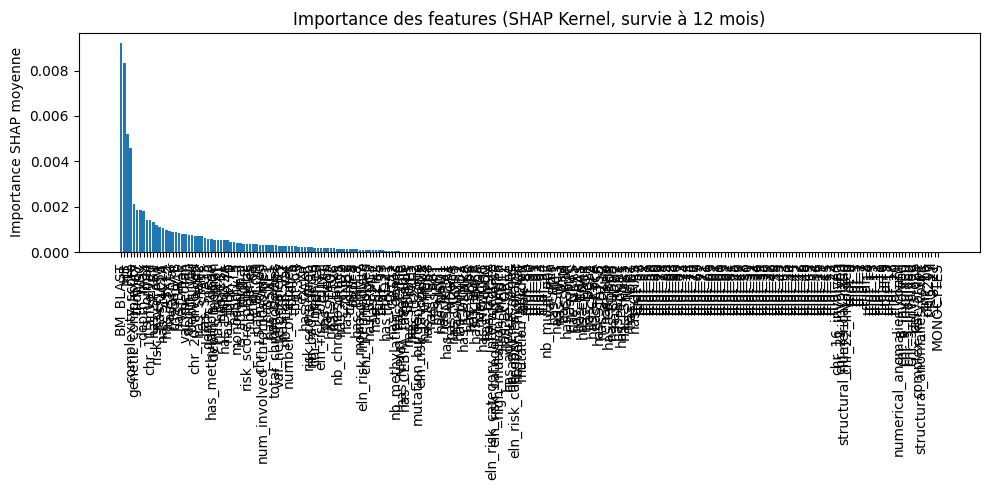

In [24]:
import torch
import shap
import numpy as np
import matplotlib.pyplot as plt

# ⚙️ Paramètres
T_max = 60
n_intervals = 41
t_target = 12

time_grid = np.linspace(0, T_max, n_intervals)
time_idx = np.argmin(np.abs(time_grid - t_target))

print(f"Temps cible {t_target} → intervalle index {time_idx} (≈ {time_grid[time_idx]:.1f})")

background_np = X_features.iloc[:100].values
test_sample_np = X_features.iloc[100:120].values
features = np.array(X_features.columns)

model.eval()

# Fonction prédictive pour SHAP : proba de survie à t_target
def predict_fn(x_numpy):
    x_torch = torch.tensor(x_numpy, dtype=torch.float32)
    with torch.no_grad():
        logits = model(x_torch)  # (batch_size, n_intervals)
        surv = mtlr_survival(logits)  # (batch_size, n_intervals), valeurs entre 0 et 1
        y_target = surv[:, time_idx].numpy()  # proba de survie à t_target
    return y_target

explainer = shap.KernelExplainer(predict_fn, background_np)

# Valeurs SHAP
shap_values = explainer.shap_values(test_sample_np, nsamples=100)

feature_importance = np.mean(np.abs(shap_values), axis=0)
sorted_idx = np.argsort(feature_importance)[::-1]

plt.figure(figsize=(10, 5))
plt.bar(features[sorted_idx], feature_importance[sorted_idx])
plt.xticks(rotation=90)
plt.title(f"Importance des features (SHAP Kernel, survie à {t_target} mois)")
plt.ylabel("Importance SHAP moyenne")
plt.tight_layout()
plt.show()

In [25]:
import pandas as pd

# Création du tableau d'importance trié
shap_df = pd.DataFrame({
    "feature": features[sorted_idx],
    "importance": feature_importance[sorted_idx]
}).reset_index(drop=True)

# Affichage markdown pour LLM
print("\nTableau markdown pour LLM :\n")
print(shap_df.to_markdown(index=False))


Tableau markdown pour LLM :

| feature                        |   importance |
|:-------------------------------|-------------:|
| BM_BLAST                       |  0.00920469  |
| HB                             |  0.0083339   |
| PLT                            |  0.00521865  |
| complexity_score               |  0.00458192  |
| genetic_complexity             |  0.00213011  |
| tfidf_67                       |  0.00186794  |
| WBC                            |  0.00186487  |
| depth_max                      |  0.00178917  |
| is_normal                      |  0.00140275  |
| chr_11_involved                |  0.00140031  |
| has_SF3B1                      |  0.00132728  |
| risk_score_raw                 |  0.00119719  |
| has_TP53                       |  0.00112187  |
| has_SMC1A                      |  0.00107861  |
| has_ASXL2                      |  0.000979784 |
| has_TET2                       |  0.000928693 |
| vaf_var                        |  0.00089599  |
| trisomy_8         